In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style("whitegrid")


In [49]:
data_df = pd.read_csv("./Data.csv")
stock_df = pd.read_csv("./StockPrice.csv")

In [50]:
data_df.head()

,Date,Data
0,2025-03-26,2.369
1,2025-03-25,2.365
2,2025-03-24,2.367
3,2025-03-21,2.386
4,2025-03-20,2.387


In [51]:
stock_df.head()

,Date,Price
0,2025-03-26,5759.50
1,2025-03-25,5826.50
2,2025-03-24,5815.50
3,2025-03-21,5718.25
4,2025-03-20,5712.75


In [52]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3902 entries, 0 to 3901
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3902 non-null   object 
 1   Data    3902 non-null   float64
dtypes: float64(1), object(1)
memory usage: 61.1+ KB


In [53]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3839 non-null   object 
 1   Price   3839 non-null   float64
dtypes: float64(1), object(1)
memory usage: 60.1+ KB


In [54]:
data_df["Date"] = pd.to_datetime(data_df["Date"])
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
data_df.sort_values("Date", inplace=True)
stock_df.sort_values("Date", inplace=True)
df = pd.merge(data_df, stock_df, on="Date", how="inner")

In [55]:
df.head()

,Date,Data,Price
0,2010-01-04,0.700,1178.00
1,2010-01-05,0.699,1181.50
2,2010-01-06,0.694,1182.25
3,2010-01-07,0.692,1186.75
4,2010-01-08,0.691,1190.75


In [56]:
df["Change_in_Data"] = df["Data"].diff()
df["Next_Day_Price"] = df["Price"].shift(-1)

In [57]:
df.isnull().sum()

Date              0
Data              0
Price             0
Change_in_Data    1
Next_Day_Price    1
dtype: int64

In [58]:
df.dropna(inplace=True)

In [59]:
df.head()

,Date,Data,Price,Change_in_Data,Next_Day_Price
1,2010-01-05,0.699,1181.50,-0.001,1182.25
2,2010-01-06,0.694,1182.25,-0.005,1186.75
3,2010-01-07,0.692,1186.75,-0.002,1190.75
4,2010-01-08,0.691,1190.75,-0.001,1191.75
5,2010-01-11,0.689,1191.75,-0.002,1183.25


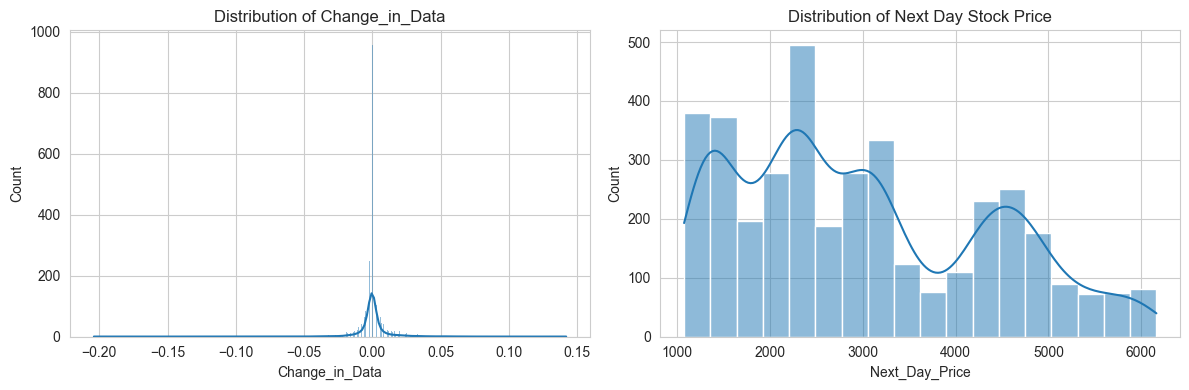

In [60]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df["Change_in_Data"], kde=True)
plt.title("Distribution of Change_in_Data")

plt.subplot(1,2,2)
sns.histplot(df["Next_Day_Price"], kde=True)
plt.title("Distribution of Next Day Stock Price")

plt.tight_layout()
plt.show()


In [61]:
df["Change_in_Data"].skew(),df["Next_Day_Price"].skew()


(-0.6494742697237852, 0.48450480296157805)

In [62]:

low_change = df["Change_in_Data"].quantile(0.01)
high_change = df["Change_in_Data"].quantile(0.99)

df["Change_in_Data"] = df["Change_in_Data"].clip(
    lower=low_change,
    upper=high_change
)

low_price = df["Next_Day_Price"].quantile(0.01)
high_price = df["Next_Day_Price"].quantile(0.99)

df["Next_Day_Price"] = df["Next_Day_Price"].clip(
    lower=low_price,
    upper=high_price
)


In [63]:

df["Change_Lag_1"] = df["Change_in_Data"].shift(1)
df["Change_Lag_2"] = df["Change_in_Data"].shift(2)
df["Change_Mean_3"] = df["Change_in_Data"].rolling(3).mean()
df["Change_Std_3"] = df["Change_in_Data"].rolling(3).std()

df.dropna(inplace=True)


In [64]:
X = df[
    ["Change_in_Data", "Change_Lag_1", "Change_Lag_2",
     "Change_Mean_3", "Change_Std_3"]
]

y = df["Next_Day_Price"]

X.head(),   y.head()


(   Change_in_Data  Change_Lag_1  Change_Lag_2  Change_Mean_3  Change_Std_3
 3          -0.002        -0.005        -0.001      -0.002667      0.002082
 4          -0.001        -0.002        -0.005      -0.002667      0.002082
 5          -0.002        -0.001        -0.002      -0.001667      0.000577
 6          -0.004        -0.002        -0.001      -0.002333      0.001528
 7          -0.001        -0.004        -0.002      -0.002333      0.001528,
 3    1190.75
 4    1191.75
 5    1183.25
 6    1190.75
 7    1194.50
 Name: Next_Day_Price, dtype: float64)

In [4]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df["Change_in_Data"], kde=True)
plt.title("Distribution of Change_in_Data after Data Preprocessing ")

plt.subplot(1,2,2)
sns.histplot(df["Next_Day_Price"], kde=True)
plt.title("Distribution of Next Day Stock Price after Data Preprocessing")

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [66]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1,1))


In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=False
)


In [69]:


def train_evaluate_model(model, 
                         X_train, X_test, 
                         y_train, y_test, 
                         y_scaler):
   
    model.fit(X_train, y_train)

    y_pred_scaled = model.predict(X_test)

    if y_pred_scaled.ndim == 1:
        y_pred_scaled = y_pred_scaled.reshape(-1, 1)

    if y_test.ndim == 1:
        y_test_scaled = y_test.reshape(-1, 1)
    else:
        y_test_scaled = y_test

 
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_test_original = y_scaler.inverse_transform(y_test_scaled)


    mae = mean_absolute_error(y_test_original, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
    r2 = r2_score(y_test_original, y_pred)

    print(f"Model: {model.__class__.__name__}")
    print(f"MAE : {mae}")
    print(f"RMSE: {rmse}")
    print(f"R2  : {r2}")
    print("-" * 40)

  


In [70]:
lr_model = LinearRegression()

train_evaluate_model(
    model=lr_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_scaler=y_scaler
)

Model: LinearRegression
MAE : 1707.6666939034228
RMSE: 1884.848248822352
R2  : -8.435402508597086
----------------------------------------


In [71]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=3.0)

train_evaluate_model(
    model=ridge_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_scaler=y_scaler
)


Model: Ridge
MAE : 1670.0918287919105
RMSE: 1864.5271624529005
R2  : -8.233047713825199
----------------------------------------


In [72]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

train_evaluate_model(
    model=rf_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train.ravel(),  
    y_test=y_test,
    y_scaler=y_scaler
)


Model: RandomForestRegressor
MAE : 2002.918266982169
RMSE: 2181.8768691320206
R2  : -11.643523706256444
----------------------------------------


In [73]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

train_evaluate_model(
    model=gbr_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train.ravel(),
    y_test=y_test,
    y_scaler=y_scaler
)


Model: GradientBoostingRegressor
MAE : 2120.6197545502127
RMSE: 2291.5483100688766
R2  : -12.946514593039524
----------------------------------------


In [74]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

train_evaluate_model(
    model=xgb_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train.ravel(),
    y_test=y_test,
    y_scaler=y_scaler
)


Model: XGBRegressor
MAE : 1997.5744535233348
RMSE: 2171.037816221018
R2  : -11.51821560700259
----------------------------------------


In [76]:
from sklearn.model_selection import RandomizedSearchCV

In [78]:
rf = RandomForestRegressor(random_state=42)

param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

In [86]:
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\sahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [87]:
best_rf = rf_random.best_estimator_

print("Best Parameters:", rf_random.best_params_)

train_evaluate_model(
    best_rf,
    X_train,
    X_test,
    y_train,
    y_test,
     y_scaler
)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}


C:\Users\sahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model: RandomForestRegressor
MAE : 2061.2506098492286
RMSE: 2185.9832426502408
R2  : -11.691159655318808
----------------------------------------


In [88]:
gbr = GradientBoostingRegressor(random_state=42)

param_dist_gbr = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.8, 1.0],
    "min_samples_split": [2, 5, 10]
}

In [89]:
gbr_random = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist_gbr,
    n_iter=20,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

gbr_random.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\sahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [2, 3, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [90]:
best_gbr = gbr_random.best_estimator_

print("Best Parameters:", gbr_random.best_params_)

train_evaluate_model(
    best_gbr,
    X_train,
    X_test,
    y_train,
    y_test,
    y_scaler
)


Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 2, 'learning_rate': 0.05}


C:\Users\sahil\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Model: GradientBoostingRegressor
MAE : 2036.8142275257198
RMSE: 2199.0482760600003
R2  : -11.843316290190158
----------------------------------------
